In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

# Предобработка данных

In [3]:
df = pd.DataFrame(data = [[1, 2.43, None, None, 'Yes'], [2, 1.3, None, 'ABC', 'No'], 
                          [2, 2.4, '2011-11-11 11:34:31', None, 'Yes'], 
                          [None, None, None, 'ABC', None]], 
                  columns=['numer', 'fl', 'datatime', 'str', 'bin'])
df.to_csv('example.csv', index=False)

## Общие методы

Загрузка с датами

In [4]:
df = pd.read_csv('example.csv', parse_dates=['datatime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   numer     3 non-null      float64       
 1   fl        3 non-null      float64       
 2   datatime  1 non-null      datetime64[ns]
 3   str       2 non-null      object        
 4   bin       3 non-null      object        
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 288.0+ bytes


In [5]:
df

,numer,fl,datatime,str,bin
0,1.0,2.43,NaT,NaN,Yes
1,2.0,1.30,NaT,ABC,No
2,2.0,2.40,2011-11-11 11:34:31,NaN,Yes
3,NaN,NaN,NaT,ABC,NaN


Описание данных

In [6]:
df.describe()

,numer,fl
count,3.000000,3.000000
mean,1.666667,2.043333
std,0.577350,0.643920
min,1.000000,1.300000
25%,1.500000,1.850000
50%,2.000000,2.400000
75%,2.000000,2.415000
max,2.000000,2.430000


Изменение типа колонок

In [7]:
def prepare_types(df, columns=[], type_cols='string'):
    df[columns] = df[columns].astype(type_cols)
    return df

Заполнение колонок по правилу

In [8]:
def fillna(df, columns=[], type_fill='mean', fill_val=None):
    if fill_val is None:
        if type_fill == 'mean':
            fill_val = df[columns].dropna().mean()
        elif type_fill == 'median':
            fill_val = df[columns].dropna().median()
        elif type_fill == 'mode':
            fill_val = df[columns].dropna().mode()
        else:
            fill_val = df[columns].dropna().mode()
    for col in columns:
        df[col] = df[col].fillna(fill_val[col])
    return df

Поиск наиболее часто встречающегося значения

In [9]:
def str_mode(col):
    vals, counts = np.unique(col.dropna(), return_counts=True)
    return vals[np.where(counts == np.max(counts))][0]

## Числовые значения

Заполнение

In [10]:
numeric_cols = ['numer', 'fl']
df = fillna(df, columns=numeric_cols)
df

,numer,fl,datatime,str,bin
0,1.000000,2.430000,NaT,NaN,Yes
1,2.000000,1.300000,NaT,ABC,No
2,2.000000,2.400000,2011-11-11 11:34:31,NaN,Yes
3,1.666667,2.043333,NaT,ABC,NaN


Корелляция. `numeric_cols` - имена столбцов

In [11]:
df[numeric_cols].corr()

,numer,fl
numer,1.000000,-0.520038
fl,-0.520038,1.000000


<AxesSubplot:>

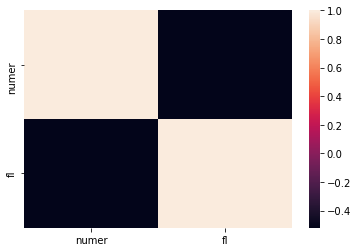

In [12]:
sns.heatmap(df[numeric_cols].corr())

Избавляемся от пары признаков с корелляцией corr > 0.9  

In [13]:
target = 'numer' # Целевая переменная
df[numeric_cols].corr()[target].sort_values(ascending=False)

numer    1.000000
fl      -0.520038
Name: numer, dtype: float64

Избавляемся от признаков с корелляцией с целевой переменной |corr| < 0.05

## Дата-время

Признак `DateTime` - признак даты / времени

In [14]:
datetime_cols = ['datatime']

Напишем функцию, подготавливающую данные. Самое часто используемое время - в секундах. Переводим время в секунды для обучения

In [15]:
def prepared_datetime(df, columns=[], type_cols='int64', to='s'):
    # We start with new day so we translate to seconds
    if to.lower() in ['s', 'sec', 'seconds']:
        translate_time = 1e9
    elif to.lower() in ['m', 'min', 'minutes']:
        translate_time = 6e10
    elif to.lower() in ['h', 'hour', 'hours']:
        translate_time = 3.6e12
    else:
        translate_time = 1
    df[columns] = df[columns].astype(type_cols) // translate_time
    df[columns] = df[columns].astype(type_cols)
    return df

Заполняем пропуски часто встречающимися значениями, преобразуем дату и время в секунды

In [16]:
mode_datetime = df[datetime_cols].apply(str_mode)

In [17]:
df = fillna(df, datetime_cols, fill_val=mode_datetime)
df = prepared_datetime(df, columns=datetime_cols)
df[datetime_cols]

,datatime
0,1321011271
1,1321011271
2,1321011271
3,1321011271


С достаточно хорошей точностью можно заполнить средним по столбцу

## Строки

In [18]:
str_vals=['str']

Заполнение часто встречающимися значениями

In [19]:
mode_str = df[str_vals].apply(str_mode)
df = fillna(df, str_vals, fill_val=mode_str)

Перекодировка

In [20]:
df = pd.get_dummies(df, columns=str_vals)

## Бинарные значения

In [21]:
bin_cols=['bin']

Заполнение часто встречающимися значениями

In [22]:
mode_str = df[bin_cols].apply(str_mode)
df = fillna(df, bin_cols, fill_val=mode_str)

Перекодировка

In [23]:
values = np.unique(df[bin_cols])
values

array(['No', 'Yes'], dtype=object)

In [24]:
mapping = {'Yes': 1, 'No': 2}
for col in bin_cols:
    df[col] = df[col].map(mapping)

# Резюме

In [25]:
df.isna().sum()

numer       0
fl          0
datatime    0
bin         0
str_ABC     0
dtype: int64

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   numer     4 non-null      float64
 1   fl        4 non-null      float64
 2   datatime  4 non-null      int64  
 3   bin       4 non-null      int64  
 4   str_ABC   4 non-null      uint8  
dtypes: float64(2), int64(2), uint8(1)
memory usage: 260.0 bytes


In [27]:
df.head()

,numer,fl,datatime,bin,str_ABC
0,1.000000,2.430000,1321011271,1,1
1,2.000000,1.300000,1321011271,2,1
2,2.000000,2.400000,1321011271,1,1
3,1.666667,2.043333,1321011271,1,1


# Все-в-одном

In [28]:
def later_prepare(df):
    # TODO later
    return df

In [29]:
def prepare_dataset(filename='example.csv', 
                    parse_dates=['datatime'], 
                    numeric_cols = ['numer', 'fl'], 
                    datetime_cols = ['datatime'],
                    bin_cols=['bin'], 
                    str_cols=['str'],
                    mapping = {'Yes': 1, 'No': 0}):
    df = pd.read_csv(filename, parse_dates=parse_dates)
    # Numeric values
    # fill
    df = fillna(df, columns=numeric_cols)
    # Datetime values
    mode_datetime = df[datetime_cols].apply(str_mode)
    df = fillna(df, datetime_cols, fill_val=mode_datetime)
    df = prepared_datetime(df, columns=datetime_cols)
    # String values
    mode_str = df[str_vals].apply(str_mode)
    df = fillna(df, str_vals, fill_val=mode_str)
    # One-hot encoding
    df = pd.get_dummies(df, columns=str_vals)
    # Binary values
    # fill
    mode_bin = df[bin_cols].apply(str_mode)
    df = fillna(df, bin_cols, fill_val=mode_bin)
    # mapping
    mapping = {'Yes': 1, 'No': 2}
    for col in bin_cols:
        df[col] = df[col].map(mapping)
    return df

In [30]:
df = prepare_dataset()

# Сохранение датасета

In [31]:
df = prepare_dataset()

In [32]:
df.to_csv('example_preprocessed.csv', index=False)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   numer     4 non-null      float64
 1   fl        4 non-null      float64
 2   datatime  4 non-null      int64  
 3   bin       4 non-null      int64  
 4   str_ABC   4 non-null      uint8  
dtypes: float64(2), int64(2), uint8(1)
memory usage: 260.0 bytes


In [34]:
df_prep = pd.read_csv('example_preprocessed.csv')
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   numer     4 non-null      float64
 1   fl        4 non-null      float64
 2   datatime  4 non-null      int64  
 3   bin       4 non-null      int64  
 4   str_ABC   4 non-null      int64  
dtypes: float64(2), int64(3)
memory usage: 288.0 bytes


In [35]:
df_prep

,numer,fl,datatime,bin,str_ABC
0,1.000000,2.430000,1321011271,1,1
1,2.000000,1.300000,1321011271,2,1
2,2.000000,2.400000,1321011271,1,1
3,1.666667,2.043333,1321011271,1,1
